In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline

input_path = './chest_XrayCat/'
classes = ['BACTERIAL', 'NORMAL', 'VIRAL']

img_dims = 150
epochs = 25
batch_size = 96

def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255, zoom_range=0.3, shear_range=0.2, vertical_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='categorical', # no longer a binary output
        shuffle=True)

    test_gen = test_datagen.flow_from_directory(
        directory=input_path+'test',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

    test_data = []
    test_labels = []
    print(os.listdir(input_path + 'test' + '/NORMAL/'))
    for cond in ['/BACTERIAL/', '/NORMAL/', '/VIRAL/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/BACTERIAL/':
                label = 0
            elif cond == '/NORMAL/':
                label = 1
            elif cond =='/VIRAL/':
                label = 2
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

In [2]:
# for _set in ['train', 'test']:
#     n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
#     n_viral = len(os.listdir(input_path + _set + '/VIRAL'))
#     n_bacterial = len(os.listdir(input_path + _set + '/BACTERIAL'))
#     print('Set: {}, normal images: {}, viral images: {}, bacterial images: {}'.format(
#         _set, n_normal, n_viral, n_bacterial))

train_gen, test_gen, test_data, test_labels = process_data(
    img_dims, batch_size)

339-0001.jpeg', 'NORMAL2-IM-0276-0001.jpeg', 'IM-0025-0001.jpeg', 'IM-0035-0001.jpeg', 'IM-0069-0001.jpeg', 'IM-0027-0001.jpeg', 'NORMAL2-IM-0340-0001.jpeg', 'NORMAL2-IM-1427-0001.jpeg', 'NORMAL2-IM-0249-0001.jpeg', 'NORMAL2-IM-0246-0001.jpeg', 'IM-0021-0001.jpeg', 'IM-0085-0001.jpeg', 'NORMAL2-IM-0343-0001.jpeg', 'NORMAL2-IM-0380-0001.jpeg', 'NORMAL2-IM-0079-0001.jpeg', 'IM-0102-0001.jpeg', 'IM-0036-0001.jpeg', 'NORMAL2-IM-0302-0001.jpeg', 'IM-0075-0001.jpeg', 'IM-0086-0001.jpeg', 'NORMAL2-IM-0322-0001.jpeg', 'NORMAL2-IM-0117-0001.jpeg', 'NORMAL2-IM-0251-0001.jpeg', 'NORMAL2-IM-0019-0001.jpeg', 'NORMAL2-IM-0317-0001.jpeg', 'NORMAL2-IM-0171-0001.jpeg', 'NORMAL2-IM-0357-0001.jpeg', 'NORMAL2-IM-0332-0001.jpeg', 'IM-0073-0001.jpeg', 'NORMAL2-IM-0105-0001.jpeg', 'IM-0030-0001.jpeg', 'NORMAL2-IM-0282-0001.jpeg', 'NORMAL2-IM-0107-0001.jpeg', 'IM-0071-0001.jpeg', 'NORMAL2-IM-0131-0001.jpeg', 'NORMAL2-IM-0301-0001.jpeg', 'NORMAL2-IM-0349-0001.jpeg', 'NORMAL2-IM-0210-0001.jpeg', 'NORMAL2-IM-027

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

inputs = layers.Input(shape=(img_dims, img_dims, 3))

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.Conv2D(32,(3, 3), activation="relu", padding="same")(x)
x = layers.MaxPool2D(padding="same")(x)

x = layers.SeparableConv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.SeparableConv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPool2D(padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.SeparableConv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.SeparableConv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPool2D(padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.SeparableConv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.SeparableConv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPool2D(padding="valid")(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(3, activation="softmax")(x)

model = Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
from datetime import datetime

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, verbose=2, mode='max')

In [5]:
hist = model.fit(
    train_gen, steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs, validation_data=test_gen,
    validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce, tensorboard_callback])

Epoch 1/25


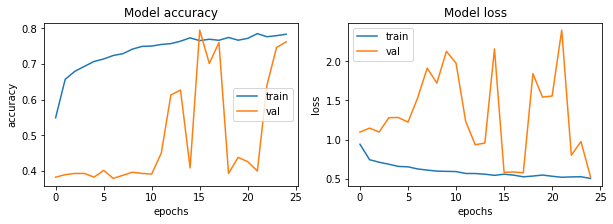

In [7]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [8]:
results = model.evaluate(test_gen)

acc = results[1] * 100

print('TEST METRICS ----------------------')
print('Accuracy: {:.2f}%'.format(acc))

print('\nTRAIN METRIC ----------------------')
print('Accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

7/7 [==============================] - 6s 721ms/step - loss: 0.5158 - accuracy: 0.7656
TEST METRICS ----------------------
Accuracy: 76.56%

TRAIN METRIC ----------------------
Accuracy: 78.36


In [8]:
model.save('./saved_models_v3/cat_' + str(epochs) + '_adam_b' + str(batch_size) + '_a' + str(int(acc)))

INFO:tensorflow:Assets written to: ./models/cat_25_adam_b96_a85/assets


# Generate HeatMap

In [1]:
from Class.gradCAM import GradCAM
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import imutils

INPUT_PATH = './chest_XrayCat/test'
MODEL_PATH = './saved_models_v3/cat_25_adam_b96_a85/'
PNEUMONIA_TYPE = '/NORMAL/'
CLASSES = ['BACTERIAL', 'NORMAL', 'VIRAL']
IMG_INDEX = 2

model = load_model(MODEL_PATH)

path = os.listdir(INPUT_PATH + PNEUMONIA_TYPE)[IMG_INDEX]
orig = cv2.imread(INPUT_PATH + PNEUMONIA_TYPE + path)

img_array = []
img = plt.imread(INPUT_PATH + PNEUMONIA_TYPE + path)
img = cv2.resize(img, (150, 150))
img = np.dstack([img, img, img])
img = img.astype('float32') / 255
img_array.append(img)
img_array = np.array(img_array)

preds = model.predict(img_array)
i = np.argmax(preds[0])
res = CLASSES[i]

cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(img_array)

heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, res + ": {:.2f}%".format(np.max(preds) * 100), (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
            0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)

title = 'heatmap_' + res + '.png'

if cv2.imwrite(MODEL_PATH + title, output) == True:
    print("{} saved.".format(title))
else:
    print('Something went wrong.')

Heatmap heatmap_NORMAL.png saved.


# Test Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
separable_conv2d (SeparableC (None, None, None, 64)    2400      
_________________________________________________________________
separable_conv2d_1 (Separabl (None, None, None, 64)    4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 64)    2

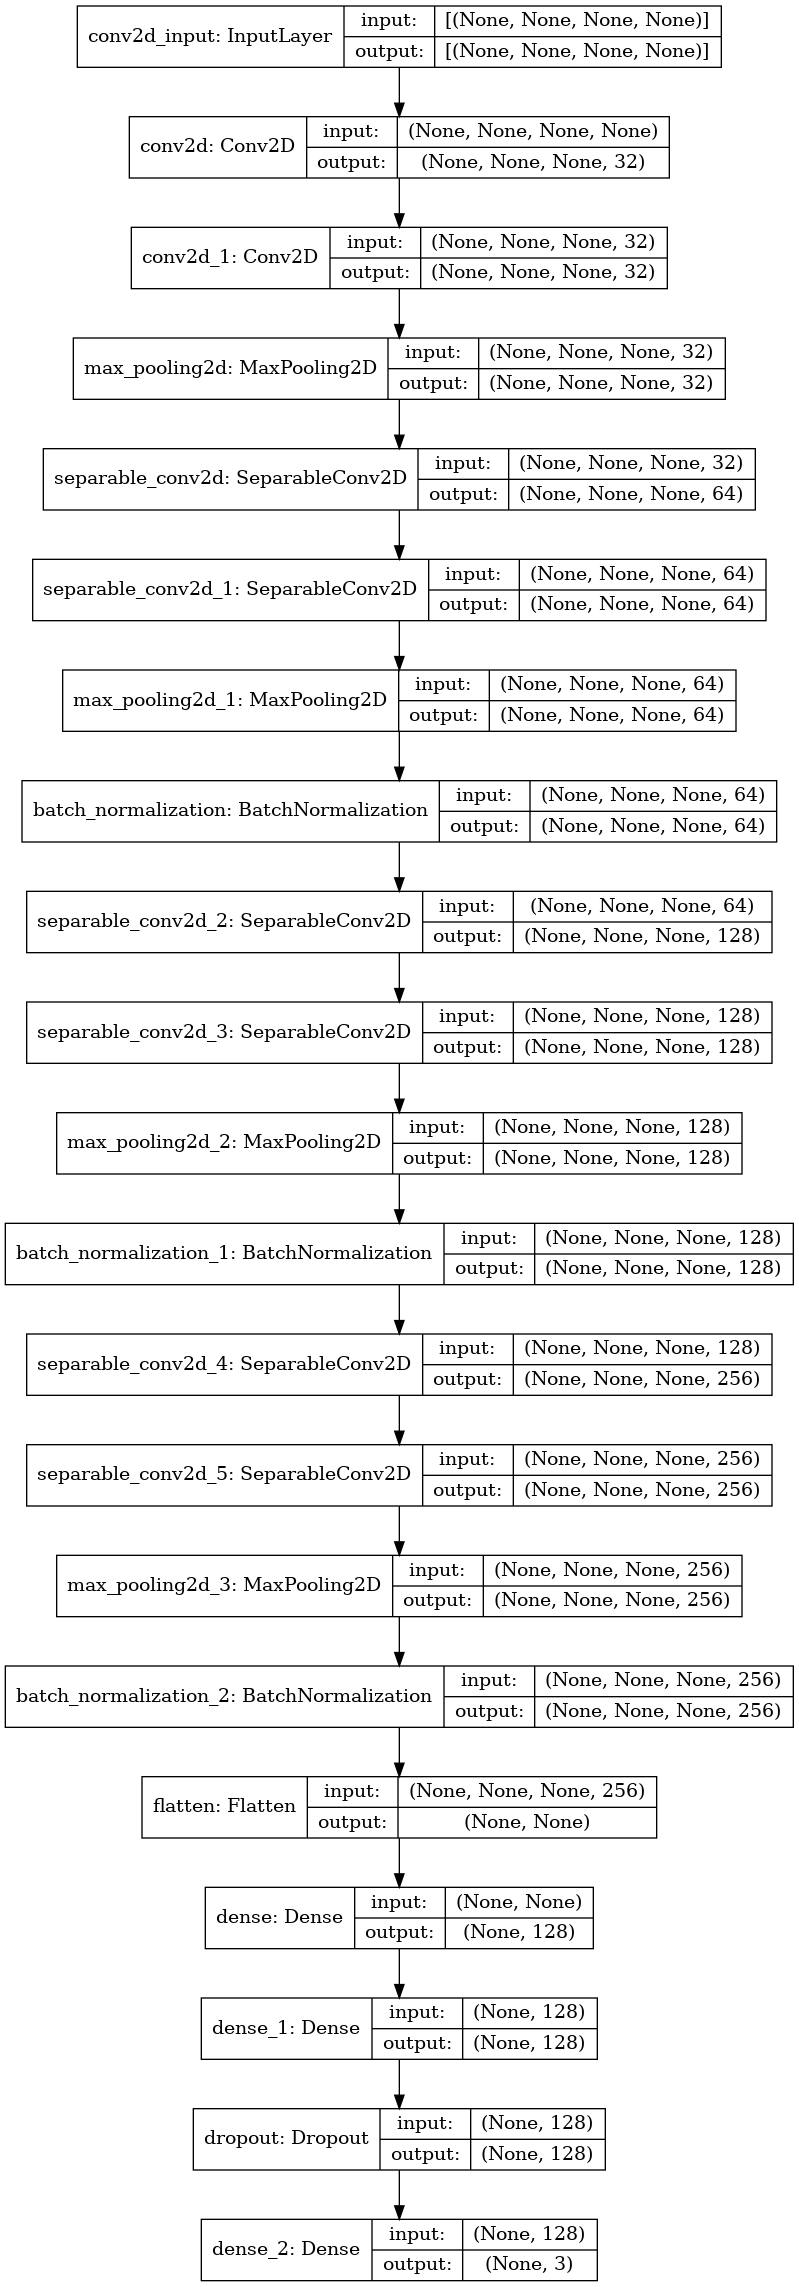

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

model_to_load = 'cat_25_adam_b96_a86'

model = None
model = load_model('./saved_models_v3/' + model_to_load)

model.summary()
plot_model(model, to_file='plot_model.png', show_shapes=True)

In [5]:
results = model.evaluate(test_gen)

acc = results[1] * 100

print('TEST METRICS ----------------------')
print('Accuracy: {:.2f}%'.format(acc))

7/7 [==============================] - 5s 625ms/step - loss: 0.4724 - accuracy: 0.8656
TEST METRICS ----------------------
Accuracy: 86.56%


This image belongs to the BACTERIAL class with a 95.73% confidence


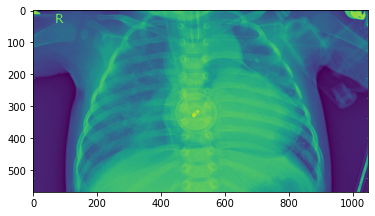

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
INPUT_PATH = './chest_XrayCat/test'
CLASSES = ['BACTERIAL', 'NORMAL', 'VIRAL']

res = []
i = 0
error = 0

# for cond in ['/BACTERIAL/', '/NORMAL/', '/VIRAL/']:  # for each folder
#     for img in os.listdir(INPUT_PATH + cond):  # for each image
#         img_array = []
#         # Import img
#         img = plt.imread(INPUT_PATH + cond + img)
#         img = cv2.resize(img, (img_dims, img_dims))
#         img = np.dstack([img, img, img])
#         img = img.astype('float32') / 255
#         img_array.append(img)
#         img_array = np.array(img_array)
#         # Feed img to CNN
#         predictions = model.predict(img_array)
#         # Retrieve prediction
#         score = "{:.2f}%".format(np.max(predictions) * 100)
#         predictions = np.argmax(predictions)
#         res.append([predictions, score])

img_array = []
img = os.listdir(INPUT_PATH + '/BACTERIAL/')[2]
img = plt.imread(INPUT_PATH + '/BACTERIAL/' + img)
img = cv2.resize(img, (img_dims, img_dims))
img = np.dstack([img, img, img])
img = img.astype('float32') / 255
img_array.append(img)
img_array = np.array(img_array)

predictions = model.predict(img_array)
score = "{:.2f}%".format(np.max(predictions) * 100)
predictions = np.argmax(predictions)
res = "This image belongs to the {} class with a {} confidence".format(CLASSES[predictions], score)

print(res)